### Trajectory Generator
Implemented via a modified version of extract_mesh.ipynb from original nerf repo

In [13]:
import os, sys
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import imageio
import pprint

import matplotlib.pyplot as plt

import run_nerf
import run_nerf_helpers

import scipy as sp


In [27]:
# Target Object Data
expname = 'target_robot_test_v2'
itrname = 'model_010000.npy'
# expname = 'lego_example'
# itrname = 'model_200000.npy'

# Room Bounds
N = 256
d = 2.4
tx = np.linspace(-d, d, N+1)
ty = np.linspace(-d, d, N+1)
tz = np.linspace(-d, d, N+1)

# Volume Threshold
thold = 10

# Trajectory Step
step = 3

Args:
expname = target_robot_test_v2
basedir = ./logs
datadir = /home/gsznaier/target_robot/nerf_training_data 
dataset_type = blender

half_res = True
no_batching = True

lrate_decay = 500
N_samples = 32
N_importance = 128

use_viewdirs = True

white_bkgd = True

N_rand = 2048
precrop_iters = 500
precrop_frac = 0.5
chunk=5000

MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
Not ndc!
Found ckpts ['target_robot_test_v2/model_010000.npy']
Reloading from target_robot_test_v2/model_010000.npy
Resetting step to 10001
Reloading fine from target_robot_test_v2/model_fine_010000.npy
Render kwargs:
{'N_importance': 128,
 'N_samples': 32,
 'far': <tf.Tensor: id=16774, shape=(), dtype=float32, numpy=6.0>,
 'lindisp': False,
 'ndc': False,
 'near': <tf.Tensor: id=16773, shape=(), dtype=float32, numpy=2.0>,
 'network_fine': <tensorflow.python.keras.engine.training.Model object at 0x7fc2fecbf850>,
 'network_fn':

2022-03-18 10:42:51.165617: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 403200000 exceeds 10% of system memory.
2022-03-18 10:42:51.319130: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 576000000 exceeds 10% of system memory.


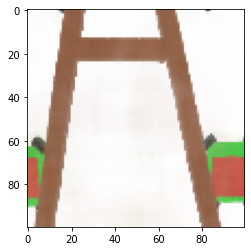

In [15]:
config = os.path.join(expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())

parser = run_nerf.config_parser()
ft_str = '' 
ft_str = '--ft_path {}'.format(os.path.join(expname, itrname))
args = parser.parse_args('--config {} '.format(config) + ft_str)

# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : tf.cast(2., tf.float32),
    'far' : tf.cast(6., tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)

net_fn = render_kwargs_test['network_query_fn']
print(net_fn)

# Render an overhead view to check model was loaded correctly
c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
c2w[2,-1] = 4.
H, W, focal = 800, 800, 1200.
down = 8
test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_test)
img = np.clip(test[0],0,1)
plt.imshow(img)
plt.show()

### Query network on dense 3d grid of points

(257, 257, 257, 3)
(257, 257, 257, 4)


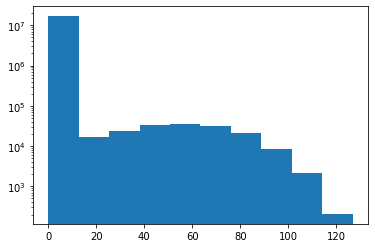

In [16]:
query_pts = np.stack(np.meshgrid(tx, ty, tz), -1).astype(np.float32)
print(query_pts.shape)
sh = query_pts.shape
flat = query_pts.reshape([-1,3])

def batchify(fn, chunk):
    if chunk is None:
        return fn
    def ret(inputs):
        return tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret
    
    
fn = lambda i0, i1 : net_fn(flat[i0:i1,None,:], viewdirs=np.zeros_like(flat[i0:i1]), network_fn=render_kwargs_test['network_fine'])
chunk = 1024*64
raw = np.concatenate([fn(i, i+chunk).numpy() for i in range(0, flat.shape[0], chunk)], 0)
raw = np.reshape(raw, list(sh[:-1]) + [-1])
sigma = np.maximum(raw[...,-1], 0.)

print(raw.shape)
plt.hist(np.maximum(0,sigma.ravel()), log=True)
plt.show()

[[ 0.9968274   0.07819974  0.01483041]
 [ 0.07804275 -0.99689066  0.01087532]
 [-0.01563476  0.00968344  0.99983084]]
[[-3.1468043   2.8341603 ]
 [-0.15890208  0.30935445]
 [-0.04255864 -0.13636723]]


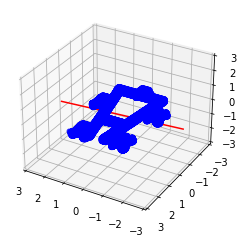

In [68]:
# Select the points that are within threshold
den_arr = np.reshape(sigma,(-1,1))
idx = np.where(den_arr>thold)[0]
X = flat[idx,:]

# Calculate mean of points
xb = np.mean(X[:,0])
yb = np.mean(X[:,1])
zb = np.mean(X[:,2])
Xb = np.array([xb,yb,zb])

# Determine the least-square fitted vector (principal component analysis)
PX = X-np.tile(Xb,(X.shape[0],1))
M = PX.T@PX
w, vl, vr = sp.linalg.eig(M, left=True)
e = vl[:,0,None]
print(vl)

# Generate waypoint
wp = np.hstack((Xb[:,None]-step*e,Xb[:,None]+step*e))
print(wp)

# Plot waypoints through object as sanity check
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], c='b', marker='o')
ax.plot3D(wp[0,:], wp[1,:], wp[2,:], 'red')

ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_zlim(-3,3)

ax.view_init(30, 120)